***Команда***
- Агапов Глеб БПМ-21-1
- Алексей Жукович БПМ-21-1
- Александр Гончаров БПМ-21-1
- Дарья Исаева БПМ-21-2

***Тема***

Разработка модели для обнаружения спама в почте

# Решение задачи классификации для обнаружения спама в письмах

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
#Для загрузки датасета
from datasets import load_dataset

#Для работы с табличными данными
import pandas as pd

#Для построения графиков
import matplotlib.pyplot as plt
import seaborn as sns

#Для кодирования категориальной переменной в численное значение
from sklearn.preprocessing import LabelEncoder

#Для перевода текста в вектора
from sklearn.feature_extraction.text import CountVectorizer

#Для рассчета метрик
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#Модель наивный байес
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

#Построение пайплайна
from sklearn.pipeline import Pipeline

#Для экспорта модели
import joblib

#
from wordcloud import WordCloud

from sklearn import set_config
set_config(display='diagram')

Для решения задачи был взят [датасет](https://huggingface.co/datasets/Deysi/spam-detection-dataset)

In [3]:
ds = load_dataset("Deysi/spam-detection-dataset")

train_dataset = ds["train"]
test_dataset = ds["test"]

train_df = train_dataset.to_pandas()
test_df = test_dataset.to_pandas()


train_df

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/581 [00:00<?, ?B/s]

(…)-00000-of-00001-daf190ce720b3dbb.parquet:   0%|          | 0.00/1.92M [00:00<?, ?B/s]

(…)-00000-of-00001-fa9b3e8ade89a333.parquet:   0%|          | 0.00/663k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8175 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2725 [00:00<?, ? examples/s]

,text,label
0,hey I am looking for Xray baggage datasets can...,not_spam
1,"""Get rich quick! Make millions in just days wi...",spam
2,URGENT MESSAGE: YOU WON'T BELIEVE WHAT WE HAVE...,spam
3,[Google AI Blog: Contributing Data to Deepfake...,not_spam
4,Trying to see if anyone already has timestamps...,not_spam
...,...,...
8170,"Hi all,\n\nWe create datasets by taking pictur...",not_spam
8171,DEALS! DEALS! DEALS!\n\nHey peeps! You won't b...,spam
8172,Hi\n\nI am working on a project and need penal...,not_spam
8173,Do you want to BLOW UP your social media follo...,spam


Для начала рассмотрим баланс классов для каждой части датасета

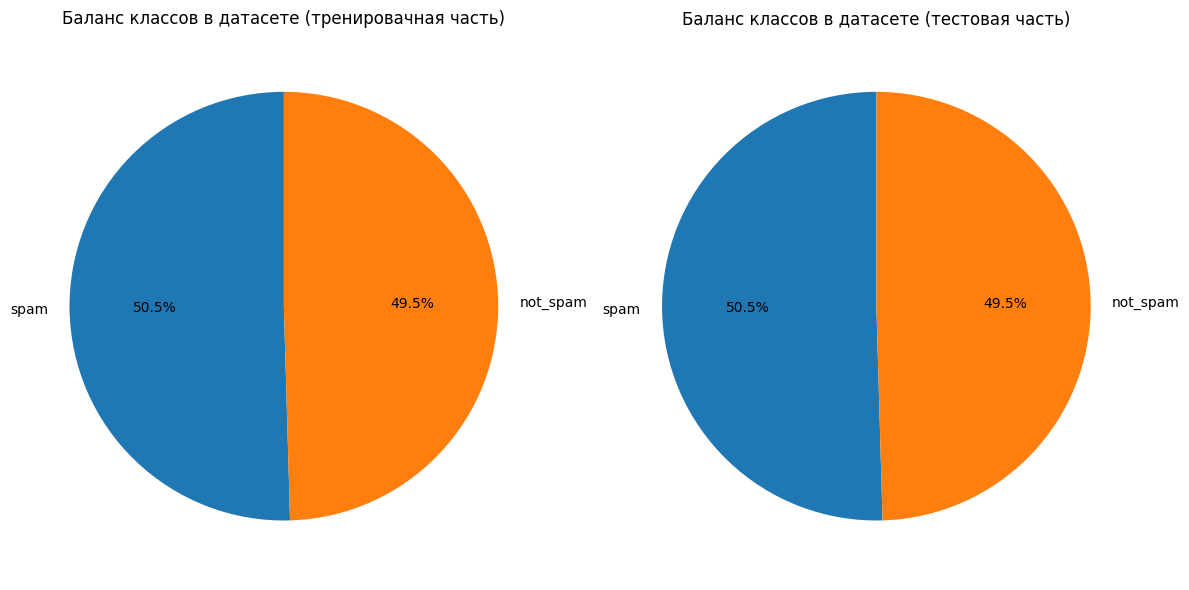

In [4]:
class_counts_train = train_df['label'].value_counts()
class_counts_test = train_df['label'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].pie(class_counts_train, labels=class_counts_train.index, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Баланс классов в датасете (тренировачная часть)')
axs[0].axis('equal')

axs[1].pie(class_counts_test, labels=class_counts_test.index, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Баланс классов в датасете (тестовая часть)')
axs[1].axis('equal')

plt.tight_layout()
plt.show()



Проверим датасет на пустые значения

In [5]:
print(test_df.isna().sum())
print(train_df.isna().sum())

text     0
label    0
dtype: int64
text     0
label    0
dtype: int64


Отобразим популярные слова в спам сообщениях

Filter:   0%|          | 0/8175 [00:00<?, ? examples/s]

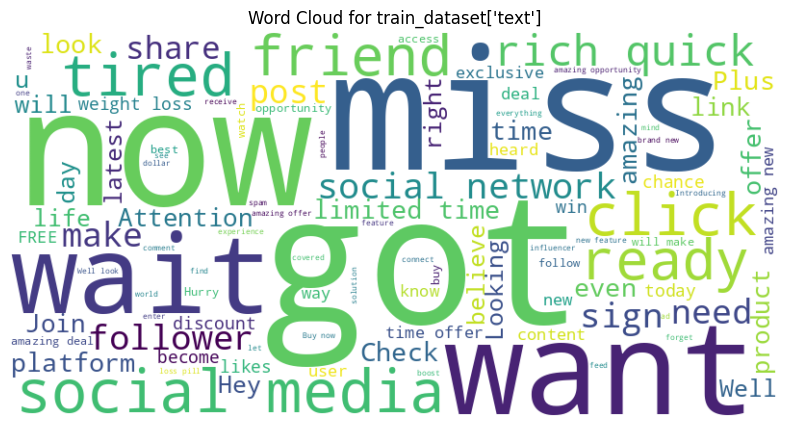

In [6]:
spam_dataset = train_dataset.filter(lambda example: example['label'] == "spam")

texts = spam_dataset['text']

all_text = " ".join(texts)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=None,
    max_words=100,
    colormap='viridis'
).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Отключаем оси
plt.title("Word Cloud for train_dataset['text']")
plt.show()

Предобработаем текст, а именно:
1. весь текст переведем в нижний регистр



In [7]:
train_df['text'] = train_df['text'].str.lower()
test_df['text'] = test_df['text'].str.lower()

Переведем наши целевые значения в числа. А именно не спам - 0, спам - 1

In [8]:
encoder = LabelEncoder()
train_df['label'] = encoder.fit_transform(train_df['label'])
test_df['label'] = encoder.fit_transform(test_df['label'])

In [17]:
X_train, y_train = train_df["text"], train_df["label"]
X_test, y_test = test_df["text"], test_df["label"]

vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

classifier_NB = MultinomialNB()
classifier_NB.fit(X_train_vectorized, y_train)

classifier_LR = LogisticRegression()
classifier_LR.fit(X_train_vectorized, y_train)

LogisticRegression()

Наивный Байес
Accuracy: 0.997
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1350
           1       1.00      1.00      1.00      1375

    accuracy                           1.00      2725
   macro avg       1.00      1.00      1.00      2725
weighted avg       1.00      1.00      1.00      2725



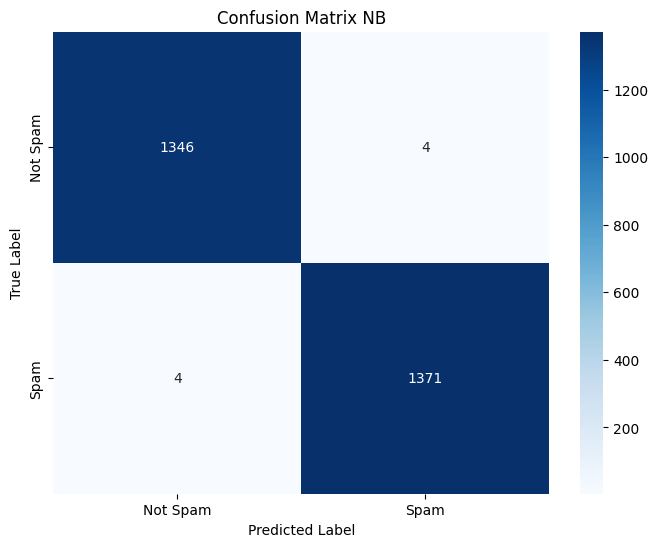

Логистическая регрессия
Accuracy: 0.996
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1350
           1       1.00      0.99      1.00      1375

    accuracy                           1.00      2725
   macro avg       1.00      1.00      1.00      2725
weighted avg       1.00      1.00      1.00      2725



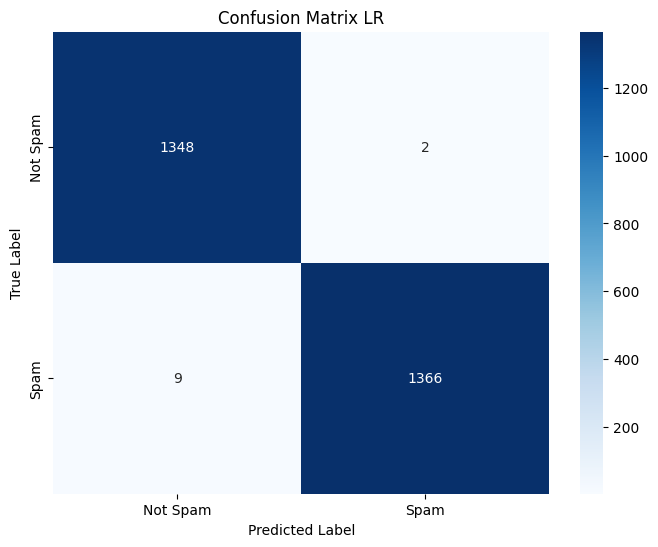

In [23]:
#Наивный Байес
y_pred_NB = classifier_NB.predict(X_test_vectorized)

accuracy_NB = accuracy_score(y_test, y_pred_NB)
confusion_NB = confusion_matrix(y_test, y_pred_NB)
report_NB = classification_report(y_test, y_pred_NB)
report_NB_dict = classification_report(y_test, y_pred_NB, output_dict=True)

print("Наивный Байес")
print(f"Accuracy: {accuracy_NB:.3f}")

print("Classification Report:")
print(report_NB)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_NB, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix NB')
plt.show()

#Логистическая регрессия
y_pred_LR = classifier_LR.predict(X_test_vectorized)

accuracy_LR = accuracy_score(y_test, y_pred_LR)
confusion_LR = confusion_matrix(y_test, y_pred_LR)
report_LR = classification_report(y_test, y_pred_LR)
report_LR_dict = classification_report(y_test, y_pred_LR, output_dict=True)

print("Логистическая регрессия")
print(f"Accuracy: {accuracy_LR:.3f}")

print("Classification Report:")
print(report_LR)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_LR, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix LR')
plt.show()

In [28]:
data = {
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Support'],
    'Naive Bayes (Class 0)': [report_NB_dict['0']['precision'], report_NB_dict['0']['recall'], report_NB_dict['0']['f1-score'], report_NB_dict['0']['support']],
    'Naive Bayes (Class 1)': [report_NB_dict['1']['precision'], report_NB_dict['1']['recall'], report_NB_dict['1']['f1-score'], report_NB_dict['1']['support']],
    'Logistic Regression (Class 0)': [report_LR_dict['0']['precision'], report_LR_dict['0']['recall'], report_LR_dict['0']['f1-score'], report_LR_dict['0']['support']],
    'Logistic Regression (Class 1)': [report_LR_dict['1']['precision'], report_LR_dict['1']['recall'], report_LR_dict['1']['f1-score'], report_LR_dict['1']['support']],
}

df = pd.DataFrame(data)

display(df)

,Metric,Naive Bayes (Class 0),Naive Bayes (Class 1),Logistic Regression (Class 0),Logistic Regression (Class 1)
0,Precision,0.997037,0.997091,0.993368,0.998538
1,Recall,0.997037,0.997091,0.998519,0.993455
2,F1-Score,0.997037,0.997091,0.995936,0.995990
3,Support,1350.000000,1375.000000,1350.000000,1375.000000


In [33]:
accuracy_data = {
    'Algorithm': ['Naive Bayes', 'Logistic Regression'],
    'Accuracy': [round(accuracy_NB, 3), round(accuracy_LR,3)]
}

df_accuracy_data = pd.DataFrame(accuracy_data)

display(df_accuracy_data)

,Algorithm,Accuracy
0,Naive Bayes,0.997
1,Logistic Regression,0.996


Построение пайплайна

In [12]:
pipeline_NB = Pipeline([
    ('vectorizer', CountVectorizer(lowercase=True)),
    ('classifier', MultinomialNB())
])

pipeline_NB.fit(X_train, y_train)

y_pred_NB = pipeline_NB.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_NB)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9970642201834863


In [13]:
pipeline_NB

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

Экспорт моделей

In [15]:
joblib.dump(pipeline_NB, 'pipeline_model_NB.joblib')

['pipeline_model_NB.joblib']

# Пример использования пайплайна

In [16]:
loaded_pipeline_NB = joblib.load('pipeline_model_NB.joblib')

new_data = ["URGENT MESSAGE: YOU WON'T BELIEVE WHAT WE HAVE TO OFFER!!! Hey you! Yeah, you with the eyes reading this right now. Do you want to be the coolest cat on the block? Do you want to get all the likes, hearts and emojis? Do you want to be ~*POPULAR*~? Well, we have the solution for you. Introducing our brand new feature that will blow your mind and your feed! We can't give away too many details, but let's just say it involves puppies, unicorns, and a drum kit. But wait, there's more! Sign up"]

predictions, proba = loaded_pipeline_NB.predict(new_data), loaded_pipeline_NB.predict_proba(new_data)

print(predictions, [round(p, 4) for p in proba[0]])



[1] [0.0, 1.0]
